<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

sfrerich

Aim: Preprocess mouse brain single-cell data from Vanlandewijck 2018 Nature 

Dataset: https://betsholtzlab.org/VascularSingleCells/database.html

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import os
from datetime import date
from matplotlib.pyplot import rc_context

In [2]:
sc.settings.verbosity = 3

In [3]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux

In [4]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

# Load data

## Annotated 
Downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE98816 (normalized count matrix and Series Matrix File = metadata2) and https://figshare.com/collections/_/4077260 02/02/2023

In [5]:
ad = sc.read_text(main_dir+"\\P6_vasc_scRNAseq\Vanlandewijck2018\\GSE98816_Brain_samples_normalized_counts_matrix.txt.gz").transpose() # vascular cells

In [6]:
#ad = sc.read_text(main_dir+"\\P6_vasc_scRNAseq\Vanlandewijck2018\\GSE98816_Brain_samples_raw_read_counts_matrix.txt.gz").transpose()

In [7]:
ad

AnnData object with n_obs × n_vars = 3186 × 19937

In [8]:
ad_astro = sc.read_text(main_dir+"\\P6_vasc_scRNAseq\Vanlandewijck2018\\GSE99058_Brain_AC_250samples_normalized_counts_matrix.txt.gz").transpose() # astrocytes

In [9]:
ad_astro

AnnData object with n_obs × n_vars = 250 × 24490

In [10]:
# Add var

In [11]:
ad.var.head()

""
Adora1
Sntg1
Prim2
Bai3
Cflar


In [12]:
# not available

In [13]:
# Add metadata

In [14]:
meta = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\\Vanlandewijck2018\\Descriptionofeachsinglecellsamples.csv", sep=";")

In [15]:
meta.head()

,GSM ID,GSM name,organism,Mouse ID,strain,genotype,age,tissue origin,annoated cell types,BioSample ID,SRA ID,Sequenced Reads
0,GSM2612539,Brain single cell 1,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929667,SRX2798643,693266
1,GSM2612540,Brain single cell 2,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,capilEC,SAMN06929666,SRX2798644,812809
2,GSM2612541,Brain single cell 3,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929665,SRX2798645,736773
3,GSM2612542,Brain single cell 4,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,EC3,SAMN06929664,SRX2798646,655327
4,GSM2612543,Brain single cell 5,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929663,SRX2798647,629114


In [16]:
meta["tissue origin"].value_counts()

Brain    3436
Lung     1504
Name: tissue origin, dtype: int64

In [17]:
meta = meta[meta["tissue origin"] == "Brain"]

In [18]:
pd.crosstab(meta["Mouse ID"], meta["genotype"])

genotype,Cldn5(BAC)eGFP,Pdgfra-H2BGFP,Pdgfrb(BAC)eGFP/NG2dsRed,SM22-Cre;Rosa26-stop-tdTomato
Mouse ID,,,,
Mouse_151128_Female,0,107,0,0
Mouse_160107_Female,0,0,746,0
Mouse_160114_Female,720,0,0,0
Mouse_160114_Male,725,0,0,0
Mouse_160205_Female,0,0,738,0
Mouse_160301_pooled,0,150,0,0
Mouse_160622_1_Male,0,0,0,162
Mouse_160622_2_Male,0,0,0,88


In [19]:
meta["genotype"].value_counts()

Pdgfrb(BAC)eGFP/NG2dsRed         1484
Cldn5(BAC)eGFP                   1445
Pdgfra-H2BGFP                     257
SM22-Cre;Rosa26-stop-tdTomato     250
Name: genotype, dtype: int64

In [20]:
meta["annoated cell types"].value_counts()

PC         1088
capilEC     405
aEC         397
vEC         298
AC          268
EC1         228
OL          155
EC3         137
aSMC        130
vSMC        107
EC2          63
aaSMC        60
FB2          49
FB1          37
MG           14
Name: annoated cell types, dtype: int64

In [21]:
meta2 = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\\Vanlandewijck2018\\GSE98816_series_matrix.txt", sep="\t", header=None).T

In [22]:
new_header = meta2.iloc[0]
new_header = [s.lstrip('!') for s in new_header] # remove leading !
meta2 = meta2[1:]
meta2.columns = new_header
meta2.Sample_description = [s.lstrip('processed data column: ') for s in meta2.Sample_description] # remove leading text

In [23]:
meta2=meta2.reset_index()
meta2=meta2.iloc[:,1:]

In [24]:
meta2.head(3)

,Sample_title,Sample_geo_accession,Sample_status,Sample_submission_date,Sample_last_update_date,Sample_type,Sample_channel_count,Sample_source_name_ch1,Sample_organism_ch1,Sample_characteristics_ch1,...,Sample_instrument_model,Sample_library_selection,Sample_library_source,Sample_library_strategy,Sample_relation,Sample_relation,Sample_supplementary_file_1,series_matrix_table_begin,ID_REF,series_matrix_table_end
0,Brain single cell 1,GSM2612539,Public on Dec 06 2017,May 11 2017,May 15 2019,SRA,1,Brain,Mus musculus,strain: C57BL/6,...,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,NaN,GSM2612539,NaN
1,Brain single cell 2,GSM2612540,Public on Dec 06 2017,May 11 2017,May 15 2019,SRA,1,Brain,Mus musculus,strain: C57BL/6,...,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,NaN,GSM2612540,NaN
2,Brain single cell 3,GSM2612541,Public on Dec 06 2017,May 11 2017,May 15 2019,SRA,1,Brain,Mus musculus,strain: C57BL/6,...,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,NONE,NaN,GSM2612541,NaN


In [25]:
meta2.columns

Index(['Sample_title', 'Sample_geo_accession', 'Sample_status',
       'Sample_submission_date', 'Sample_last_update_date', 'Sample_type',
       'Sample_channel_count', 'Sample_source_name_ch1', 'Sample_organism_ch1',
       'Sample_characteristics_ch1', 'Sample_characteristics_ch1',
       'Sample_characteristics_ch1', 'Sample_characteristics_ch1',
       'Sample_molecule_ch1', 'Sample_extract_protocol_ch1',
       'Sample_extract_protocol_ch1', 'Sample_taxid_ch1', 'Sample_description',
       'Sample_data_processing', 'Sample_data_processing',
       'Sample_data_processing', 'Sample_platform_id', 'Sample_contact_name',
       'Sample_contact_institute', 'Sample_contact_address',
       'Sample_contact_city', 'Sample_contact_zip/postal_code',
       'Sample_contact_country', 'Sample_data_row_count',
       'Sample_instrument_model', 'Sample_library_selection',
       'Sample_library_source', 'Sample_library_strategy', 'Sample_relation',
       'Sample_relation', 'Sample_supplementar

In [26]:
meta2.Sample_description

0           Brain.EC3_A10
1           Brain.EC3_A11
2           Brain.EC3_A12
3           Brain.EC3_A13
4           Brain.EC3_A14
              ...        
3181     Brain.Pdgfra2_P1
3182    Brain.Pdgfra2_P23
3183    Brain.Pdgfra2_P24
3184     Brain.Pdgfra2_P4
3185     Brain.Pdgfra2_P7
Name: Sample_description, Length: 3186, dtype: object

In [27]:
all(meta2.Sample_geo_accession == meta2.ID_REF)

True

In [28]:
meta2["tissue origin"] = meta2['Sample_description'].str.split('.').str[0]

In [29]:
meta2["tissue origin"].value_counts()

Brain    3186
Name: tissue origin, dtype: int64

Note: Matches count of vascular cells from metadata 1 and anndata object

In [30]:
len(meta2.Sample_geo_accession.unique())

3186

All Sample_geo_accession are unique

In [31]:
all(meta2.Sample_geo_accession.isin(meta["GSM ID"]))

True

All Sample_geo_accession are in GSM ID from metadata table 1. Now we can match meta2.Sample_description (anndata descriptors) to meta["annoated cell types"]

In [32]:
# use only selected cols from meta2
meta2 = meta2[['Sample_title', 'Sample_geo_accession', 'tissue origin', 'Sample_description']]
meta2.head()

,Sample_title,Sample_geo_accession,tissue origin,Sample_description
0,Brain single cell 1,GSM2612539,Brain,Brain.EC3_A10
1,Brain single cell 2,GSM2612540,Brain,Brain.EC3_A11
2,Brain single cell 3,GSM2612541,Brain,Brain.EC3_A12
3,Brain single cell 4,GSM2612542,Brain,Brain.EC3_A13
4,Brain single cell 5,GSM2612543,Brain,Brain.EC3_A14


In [33]:
# use only selected cols from meta2
meta = meta[['GSM ID','GSM name','organism','Mouse ID','strain','genotype','age','tissue origin','annoated cell types','BioSample ID','SRA ID','Sequenced Reads']]
meta.head()

,GSM ID,GSM name,organism,Mouse ID,strain,genotype,age,tissue origin,annoated cell types,BioSample ID,SRA ID,Sequenced Reads
0,GSM2612539,Brain single cell 1,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929667,SRX2798643,693266
1,GSM2612540,Brain single cell 2,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,capilEC,SAMN06929666,SRX2798644,812809
2,GSM2612541,Brain single cell 3,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929665,SRX2798645,736773
3,GSM2612542,Brain single cell 4,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,EC3,SAMN06929664,SRX2798646,655327
4,GSM2612543,Brain single cell 5,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929663,SRX2798647,629114


In [34]:
meta.shape # contains vascular cells + 250 astrocytes

(3436, 12)

In [35]:
meta2.shape # contains vascular cells only

(3186, 4)

In [36]:
meta_merged = meta.merge(meta2, how='inner', left_on="GSM ID", right_on="Sample_geo_accession")
meta_merged.head()

,GSM ID,GSM name,organism,Mouse ID,strain,genotype,age,tissue origin_x,annoated cell types,BioSample ID,SRA ID,Sequenced Reads,Sample_title,Sample_geo_accession,tissue origin_y,Sample_description
0,GSM2612539,Brain single cell 1,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929667,SRX2798643,693266,Brain single cell 1,GSM2612539,Brain,Brain.EC3_A10
1,GSM2612540,Brain single cell 2,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,capilEC,SAMN06929666,SRX2798644,812809,Brain single cell 2,GSM2612540,Brain,Brain.EC3_A11
2,GSM2612541,Brain single cell 3,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929665,SRX2798645,736773,Brain single cell 3,GSM2612541,Brain,Brain.EC3_A12
3,GSM2612542,Brain single cell 4,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,EC3,SAMN06929664,SRX2798646,655327,Brain single cell 4,GSM2612542,Brain,Brain.EC3_A13
4,GSM2612543,Brain single cell 5,Mus musculus,Mouse_160114_Female,C57BL/6,Cldn5(BAC)eGFP,adult,Brain,aEC,SAMN06929663,SRX2798647,629114,Brain single cell 5,GSM2612543,Brain,Brain.EC3_A14


In [37]:
# format ad.obs

In [38]:
ad.obs.head()

""
Brain.Mural3_A13
Brain.Mural3_A14
Brain.Mural3_A6
Brain.Mural3_A2
Brain.Mural3_A9


This is the format of metadata in the anndata object. Corresponds to meta_merged.Sample_description

In [39]:
ad.shape

(3186, 19937)

In [40]:
temp = ad.obs.reset_index(level=0)["index"].str.split(pat=".",expand=True)
temp

,0,1
0,Brain,Mural3_A13
1,Brain,Mural3_A14
2,Brain,Mural3_A6
3,Brain,Mural3_A2
4,Brain,Mural3_A9
...,...,...
3181,Brain,Pdgfra2_P15
3182,Brain,Pdgfra2_P17
3183,Brain,Pdgfra2_P19
3184,Brain,Pdgfra2_P23


In [41]:
temp["name"] = temp[0] + "." + temp[1]

In [42]:
temp[0].value_counts()

Brain    3186
Name: 0, dtype: int64

In [43]:
temp["tissue"] = temp[0]
temp["cell_id"] = temp[1]

In [44]:
temp

,0,1,name,tissue,cell_id
0,Brain,Mural3_A13,Brain.Mural3_A13,Brain,Mural3_A13
1,Brain,Mural3_A14,Brain.Mural3_A14,Brain,Mural3_A14
2,Brain,Mural3_A6,Brain.Mural3_A6,Brain,Mural3_A6
3,Brain,Mural3_A2,Brain.Mural3_A2,Brain,Mural3_A2
4,Brain,Mural3_A9,Brain.Mural3_A9,Brain,Mural3_A9
...,...,...,...,...,...
3181,Brain,Pdgfra2_P15,Brain.Pdgfra2_P15,Brain,Pdgfra2_P15
3182,Brain,Pdgfra2_P17,Brain.Pdgfra2_P17,Brain,Pdgfra2_P17
3183,Brain,Pdgfra2_P19,Brain.Pdgfra2_P19,Brain,Pdgfra2_P19
3184,Brain,Pdgfra2_P23,Brain.Pdgfra2_P23,Brain,Pdgfra2_P23


In [45]:
temp["cell_type_fine"] = temp.cell_id.str.split(pat="_",expand=True)[0]

In [46]:
temp.cell_type_fine.value_counts()

Mural6     377
Mural3     369
Mural4     369
Mural5     369
EC6        364
EC3        361
EC5        361
EC4        359
Pdgfra2    150
Pdgfra1    107
Name: cell_type_fine, dtype: int64

In [47]:
#temp[temp["cell_type_fine"] == "EC3"].cell_id.unique()

In [48]:
pd.crosstab(temp["cell_type_fine"], temp["cell_id"])

cell_id,EC3_A1,EC3_A10,EC3_A11,EC3_A12,EC3_A13,EC3_A14,EC3_A15,EC3_A17,EC3_A18,EC3_A19,...,Pdgfra2_P13,Pdgfra2_P14,Pdgfra2_P15,Pdgfra2_P16,Pdgfra2_P17,Pdgfra2_P19,Pdgfra2_P23,Pdgfra2_P24,Pdgfra2_P4,Pdgfra2_P7
cell_type_fine,,,,,,,,,,,,,,,,,,,,,
EC3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
EC4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EC5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EC6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mural3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mural4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mural5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mural6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pdgfra1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
temp['cell_type_broad'] = temp['cell_type_fine'].str.replace('\d+', '')
temp.cell_type_broad.value_counts()

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_14392\3044782497.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  temp['cell_type_broad'] = temp['cell_type_fine'].str.replace('\d+', '')


Mural     1484
EC        1445
Pdgfra     257
Name: cell_type_broad, dtype: int64

Note: Broad cell types match between metadata and anndata objects

In [50]:
assert all(ad.obs.reset_index()["index"] == temp.name)
assert len(ad.obs) == len(temp)

In [51]:
ad.obs = temp[["tissue","cell_id","cell_type_fine","cell_type_broad","name"]]

In [52]:
# add metadata from meta_merged to anndata

In [53]:
ad.obs

,tissue,cell_id,cell_type_fine,cell_type_broad,name
0,Brain,Mural3_A13,Mural3,Mural,Brain.Mural3_A13
1,Brain,Mural3_A14,Mural3,Mural,Brain.Mural3_A14
2,Brain,Mural3_A6,Mural3,Mural,Brain.Mural3_A6
3,Brain,Mural3_A2,Mural3,Mural,Brain.Mural3_A2
4,Brain,Mural3_A9,Mural3,Mural,Brain.Mural3_A9
...,...,...,...,...,...
3181,Brain,Pdgfra2_P15,Pdgfra2,Pdgfra,Brain.Pdgfra2_P15
3182,Brain,Pdgfra2_P17,Pdgfra2,Pdgfra,Brain.Pdgfra2_P17
3183,Brain,Pdgfra2_P19,Pdgfra2,Pdgfra,Brain.Pdgfra2_P19
3184,Brain,Pdgfra2_P23,Pdgfra2,Pdgfra,Brain.Pdgfra2_P23


In [54]:
ad.obs = ad.obs.merge(meta_merged, how='inner', left_on="name", right_on="Sample_description")

D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [55]:
ad.obs.head(3)

,tissue,cell_id,cell_type_fine,cell_type_broad,name,GSM ID,GSM name,organism,Mouse ID,strain,...,age,tissue origin_x,annoated cell types,BioSample ID,SRA ID,Sequenced Reads,Sample_title,Sample_geo_accession,tissue origin_y,Sample_description
0,Brain,Mural3_A13,Mural3,Mural,Brain.Mural3_A13,GSM2613987,Brain single cell 1449,Mus musculus,Mouse_160205_Female,C57BL/6,...,adult,Brain,PC,SAMN06931994,SRX2800092,369784,Brain single cell 1449,GSM2613987,Brain,Brain.Mural3_A13
1,Brain,Mural3_A14,Mural3,Mural,Brain.Mural3_A14,GSM2613988,Brain single cell 1450,Mus musculus,Mouse_160205_Female,C57BL/6,...,adult,Brain,vSMC,SAMN06931993,SRX2800093,404665,Brain single cell 1450,GSM2613988,Brain,Brain.Mural3_A14
2,Brain,Mural3_A6,Mural3,Mural,Brain.Mural3_A6,GSM2614002,Brain single cell 1464,Mus musculus,Mouse_160205_Female,C57BL/6,...,adult,Brain,PC,SAMN06932064,SRX2800107,528106,Brain single cell 1464,GSM2614002,Brain,Brain.Mural3_A6


In [56]:
ad.obs.columns

Index(['tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name',
       'GSM ID', 'GSM name', 'organism', 'Mouse ID', 'strain', 'genotype',
       'age', 'tissue origin_x', 'annoated cell types', 'BioSample ID',
       'SRA ID', 'Sequenced Reads', 'Sample_title', 'Sample_geo_accession',
       'tissue origin_y', 'Sample_description'],
      dtype='object')

In [57]:
pd.crosstab(ad.obs["cell_type_fine"], ad.obs["annoated cell types"])

annoated cell types,AC,EC1,EC2,EC3,FB1,FB2,MG,OL,PC,aEC,aSMC,aaSMC,capilEC,vEC,vSMC
cell_type_fine,,,,,,,,,,,,,,,
EC3,0,68,11,24,0,0,0,0,0,90,0,0,100,68,0
EC4,0,48,10,23,0,0,0,0,0,94,0,0,107,77,0
EC5,0,41,15,40,0,0,1,0,0,93,0,0,99,72,0
EC6,0,43,21,36,0,0,0,0,0,108,0,0,82,74,0
Mural3,6,0,3,6,0,0,2,0,266,3,35,11,4,3,30
Mural4,4,9,1,4,0,0,0,0,261,1,29,19,10,3,28
Mural5,5,14,1,2,0,0,0,0,265,3,30,18,3,0,28
Mural6,1,5,0,2,0,0,0,0,296,3,36,12,0,1,21
Pdgfra1,2,0,0,0,20,38,8,38,0,1,0,0,0,0,0


In [58]:
ad.obs["annoated cell types"].value_counts()

PC         1088
capilEC     405
aEC         397
vEC         298
EC1         228
OL          155
EC3         137
aSMC        130
vSMC        107
EC2          63
aaSMC        60
FB2          49
FB1          37
AC           18
MG           14
Name: annoated cell types, dtype: int64

Corresponds to https://betsholtzlab.org/VascularSingleCells/database.html, except for astrocytes

In [59]:
# merge separate anndata objects of vasculature and astrocytes

In [60]:
# format ad_astro.obs

In [61]:
ad_astro.obs.head()

""
Brain.VSMC2_M16
Brain.VSMC2_G3
Brain.VSMC2_O10
Brain.VSMC2_E16
Brain.VSMC2_C7


This is the format of metadata in the anndata object. Corresponds to meta_merged.Sample_description

In [62]:
ad_astro.shape

(250, 24490)

In [63]:
temp = ad_astro.obs.reset_index(level=0)["index"].str.split(pat=".",expand=True)
temp

,0,1
0,Brain,VSMC2_M16
1,Brain,VSMC2_G3
2,Brain,VSMC2_O10
3,Brain,VSMC2_E16
4,Brain,VSMC2_C7
...,...,...
245,Brain,VSMC2_M23
246,Brain,VSMC3_M6
247,Brain,VSMC2_A3
248,Brain,VSMC3_F15


In [64]:
temp["name"] = temp[0] + "." + temp[1]

In [65]:
temp[0].value_counts()

Brain    250
Name: 0, dtype: int64

In [66]:
temp["tissue"] = temp[0]
temp["cell_id"] = temp[1]

In [67]:
temp

,0,1,name,tissue,cell_id
0,Brain,VSMC2_M16,Brain.VSMC2_M16,Brain,VSMC2_M16
1,Brain,VSMC2_G3,Brain.VSMC2_G3,Brain,VSMC2_G3
2,Brain,VSMC2_O10,Brain.VSMC2_O10,Brain,VSMC2_O10
3,Brain,VSMC2_E16,Brain.VSMC2_E16,Brain,VSMC2_E16
4,Brain,VSMC2_C7,Brain.VSMC2_C7,Brain,VSMC2_C7
...,...,...,...,...,...
245,Brain,VSMC2_M23,Brain.VSMC2_M23,Brain,VSMC2_M23
246,Brain,VSMC3_M6,Brain.VSMC3_M6,Brain,VSMC3_M6
247,Brain,VSMC2_A3,Brain.VSMC2_A3,Brain,VSMC2_A3
248,Brain,VSMC3_F15,Brain.VSMC3_F15,Brain,VSMC3_F15


In [68]:
temp["cell_type_fine"] = temp.cell_id.str.split(pat="_",expand=True)[0]

In [69]:
temp.cell_type_fine.value_counts()

VSMC2    162
VSMC3     88
Name: cell_type_fine, dtype: int64

wrong labels?

In [70]:
#temp[temp["cell_type_fine"] == "EC3"].cell_id.unique()

In [71]:
pd.crosstab(temp["cell_type_fine"], temp["cell_id"])

cell_id,VSMC2_A1,VSMC2_A11,VSMC2_A12,VSMC2_A14,VSMC2_A17,VSMC2_A18,VSMC2_A19,VSMC2_A20,VSMC2_A3,VSMC2_A4,...,VSMC3_N7,VSMC3_O1,VSMC3_O10,VSMC3_O11,VSMC3_O14,VSMC3_O18,VSMC3_O21,VSMC3_P11,VSMC3_P18,VSMC3_P19
cell_type_fine,,,,,,,,,,,,,,,,,,,,,
VSMC2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
VSMC3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [72]:
temp['cell_type_broad'] = temp['cell_type_fine'].str.replace('\d+', '')
temp.cell_type_broad.value_counts()

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_14392\3044782497.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  temp['cell_type_broad'] = temp['cell_type_fine'].str.replace('\d+', '')


VSMC    250
Name: cell_type_broad, dtype: int64

Note: Broad cell types match between metadata and anndata objects

In [73]:
assert all(ad_astro.obs.reset_index()["index"] == temp.name)
assert len(ad_astro.obs) == len(temp)

In [74]:
ad_astro.obs = temp[["tissue","cell_id","cell_type_fine","cell_type_broad","name"]]

In [75]:
ad_astro.obs["annoated cell types"] = "AC"

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_14392\1151037147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad_astro.obs["annoated cell types"] = "AC"


Merge anndata objects from vasculature and astrocytes

But first, drop 18 ACs from vasculature dataset. In https://betsholtzlab.org/VascularSingleCells/database.html exactly 250 ACs are shown, presumably from the 250 AC dataset.

In [76]:
ad = ad[~ad.obs['annoated cell types'].isin(['AC'])]

In [77]:
ad

View of AnnData object with n_obs × n_vars = 3168 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'GSM ID', 'GSM name', 'organism', 'Mouse ID', 'strain', 'genotype', 'age', 'tissue origin_x', 'annoated cell types', 'BioSample ID', 'SRA ID', 'Sequenced Reads', 'Sample_title', 'Sample_geo_accession', 'tissue origin_y', 'Sample_description'

In [78]:
ad_astro

AnnData object with n_obs × n_vars = 250 × 24490
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types'

Check if data is normalized:

In [79]:
ad.layers

LayersView with keys: 

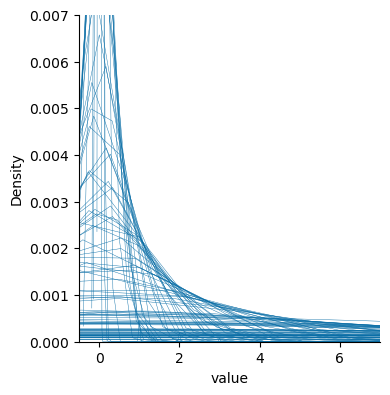

In [80]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

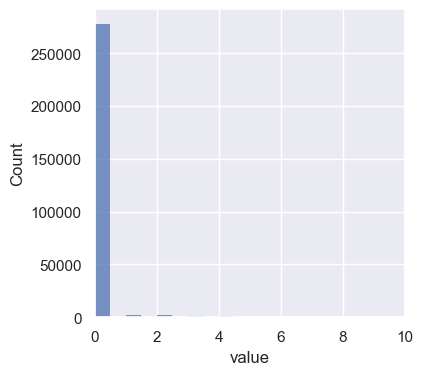

In [81]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
plt.show()

In [82]:
exp.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,281.0,13.0,120.0,...,0.0,0.0,0.0,575.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,8.0,109.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,244.0,0.0,147.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1060.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,148.0,4.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note: Data is normalized by definition (see file name)

In [83]:
ad_merged = anndata.concat([ad, ad_astro], join="inner")

D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [84]:
ad_merged

AnnData object with n_obs × n_vars = 3418 × 19937
    obs: 'tissue', 'cell_id', 'cell_type_fine', 'cell_type_broad', 'name', 'annoated cell types'

In [85]:
ad_merged.obs.head(3)

,tissue,cell_id,cell_type_fine,cell_type_broad,name,annoated cell types
0,Brain,Mural3_A13,Mural3,Mural,Brain.Mural3_A13,PC
1,Brain,Mural3_A14,Mural3,Mural,Brain.Mural3_A14,vSMC
2,Brain,Mural3_A6,Mural3,Mural,Brain.Mural3_A6,PC


In [86]:
ad_merged.obsm['X_umap'] # no umap available as expected

KeyError: 'X_umap'

In [87]:
ad_merged.obs["clusters_fine"] = ad_merged.obs["annoated cell types"]

In [88]:
ad_merged.obs["clusters"] = ad_merged.obs["annoated cell types"]

In [89]:
# merge subclusters
new_names = {
    'ECs': {'EC1','EC2','EC3','aEC','vEC','capilEC'},
    'Pericytes': {'PC'},
    'SMCs': {'aSMC','aaSMC','vSMC'},
    'Oligos': {'OL'},
    'Fibroblasts': {'FB1', 'FB2'},
    'Microglia': {'MG'},
    'Astrocytes': {'AC'}
}
# re-format
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'AC': 'Astrocytes', 'EC1': 'ECs', 'EC2': 'ECs', 'EC3': 'ECs', 'FB1': 'Fibroblasts', 'FB2': 'Fibroblasts', 'MG': 'Microglia', 'OL': 'Oligos', 'PC': 'Pericytes', 'aEC': 'ECs', 'aSMC': 'SMCs', 'aaSMC': 'SMCs', 'capilEC': 'ECs', 'vEC': 'ECs', 'vSMC': 'SMCs'}


In [90]:
ad_merged.obs['clusters'] = (
    ad_merged.obs['clusters']
    .map(new_cluster_names)
    .astype('category')
)

In [91]:
# alternative: keep AV zonation

In [92]:
# merge subclusters
new_names = {
    'ECs_non_AV': {'EC1','EC2','EC3'},
    'ECs_Arterial': {'aEC'},
    'ECs_Capillary': {'capilEC'},
    'ECs_Venous': {'vEC'},
    'Pericytes': {'PC'},
    'SMCs': {'aSMC','aaSMC','vSMC'},
    'Oligos': {'OL'},
    'Fibroblasts': {'FB1', 'FB2'},
    'Microglia': {'MG'},
    'Astrocytes': {'AC'}
}
# re-format
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'AC': 'Astrocytes', 'EC1': 'ECs_non_AV', 'EC2': 'ECs_non_AV', 'EC3': 'ECs_non_AV', 'FB1': 'Fibroblasts', 'FB2': 'Fibroblasts', 'MG': 'Microglia', 'OL': 'Oligos', 'PC': 'Pericytes', 'aEC': 'ECs_Arterial', 'aSMC': 'SMCs', 'aaSMC': 'SMCs', 'capilEC': 'ECs_Capillary', 'vEC': 'ECs_Venous', 'vSMC': 'SMCs'}


In [93]:
# fine annotation
ad_merged.obs['clusters2'] = (
    ad_merged.obs['clusters_fine']
    .map(new_cluster_names)
    .astype('category')
)

In [94]:
ad_merged.obs.clusters.value_counts()

ECs            1528
Pericytes      1088
SMCs            297
Astrocytes      250
Oligos          155
Fibroblasts      86
Microglia        14
Name: clusters, dtype: int64

In [95]:
ad_merged.obs.clusters2.value_counts()

Pericytes        1088
ECs_non_AV        428
ECs_Capillary     405
ECs_Arterial      397
ECs_Venous        298
SMCs              297
Astrocytes        250
Oligos            155
Fibroblasts        86
Microglia          14
Name: clusters2, dtype: int64

In [96]:
# exclude clusters with <50 cells
cluster_counts = ad_merged.obs['clusters'].value_counts()
cluster_counts

ECs            1528
Pericytes      1088
SMCs            297
Astrocytes      250
Oligos          155
Fibroblasts      86
Microglia        14
Name: clusters, dtype: int64

In [97]:
ad_merged = ad_merged[ad_merged.obs['clusters'].isin(cluster_counts[cluster_counts>49].index)]

# Focus on: Foxf2

In [98]:
gene="Foxf2"

## Plot

D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


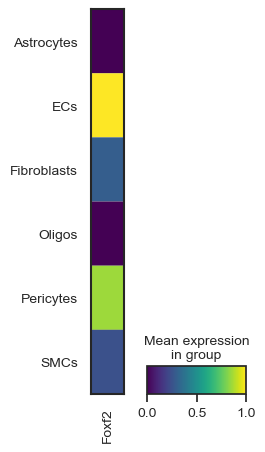

In [99]:
sns.set_theme(style='white')
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

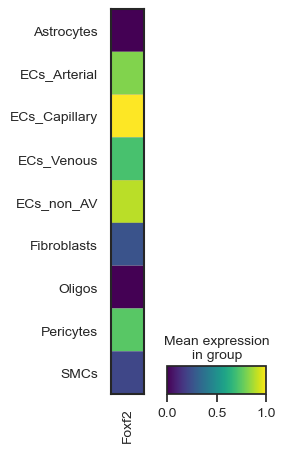

In [107]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

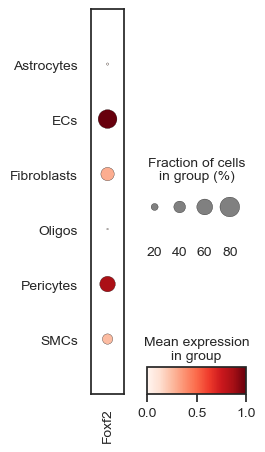

In [108]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

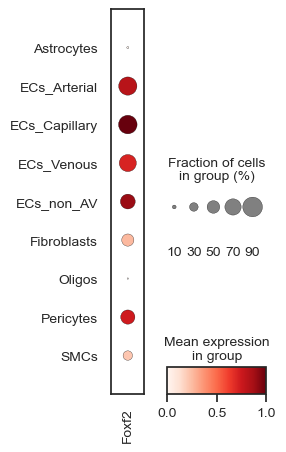

In [109]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

## Excl zonation

In [110]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000066
ECs,1.000000
Fibroblasts,0.293552
Oligos,0.000000
Pericytes,0.853845
SMCs,0.247018


In [111]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.044000
ECs,0.752618
Fibroblasts,0.476744
Oligos,0.025806
Pericytes,0.585478
SMCs,0.340067


In [112]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000066,0.044000,Foxf2,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.752618,Foxf2,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.293552,0.476744,Foxf2,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.025806,Foxf2,Vanlandewijck2018,Mouse,155
Pericytes,0.853845,0.585478,Foxf2,Vanlandewijck2018,Mouse,1088
SMCs,0.247018,0.340067,Foxf2,Vanlandewijck2018,Mouse,297


In [113]:
# export
name='Vanlandewijck2018'

In [114]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'.csv',sep=';')

## Incl zonation

In [115]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [116]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [117]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000057,0.044000,Foxf2,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.810197,0.816121,Foxf2,Vanlandewijck2018,Mouse,397
ECs_Capillary,1.000000,0.834568,Foxf2,Vanlandewijck2018,Mouse,405
ECs_Venous,0.707675,0.748322,Foxf2,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.897588,0.619159,Foxf2,Vanlandewijck2018,Mouse,428
Fibroblasts,0.253919,0.476744,Foxf2,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.025806,Foxf2,Vanlandewijck2018,Mouse,155
Pericytes,0.738566,0.585478,Foxf2,Vanlandewijck2018,Mouse,1088
SMCs,0.213667,0.340067,Foxf2,Vanlandewijck2018,Mouse,297


In [118]:
# export
name='Vanlandewijck2018'

In [119]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_incl_zonation.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [120]:
gene="Foxo1"

### Plot

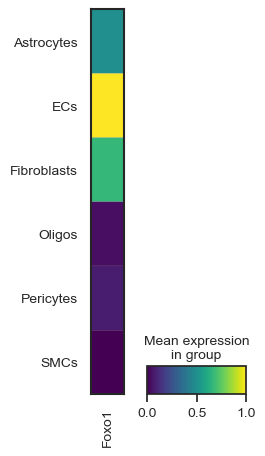

In [121]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

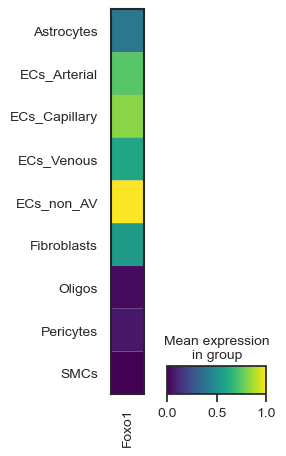

In [122]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

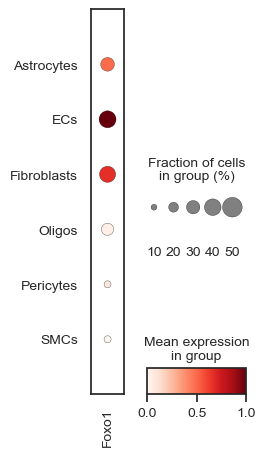

In [123]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

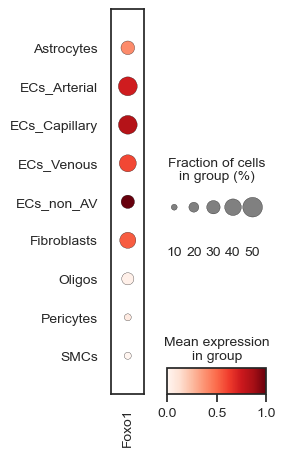

In [124]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [125]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.493353
ECs,1.000000
Fibroblasts,0.667187
Oligos,0.035463
Pericytes,0.079417
SMCs,0.000000


In [126]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.308000
ECs,0.411649
Fibroblasts,0.383721
Oligos,0.264516
Pericytes,0.125919
SMCs,0.127946


In [127]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.493353,0.308000,Foxo1,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.411649,Foxo1,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.667187,0.383721,Foxo1,Vanlandewijck2018,Mouse,86
Oligos,0.035463,0.264516,Foxo1,Vanlandewijck2018,Mouse,155
Pericytes,0.079417,0.125919,Foxo1,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.127946,Foxo1,Vanlandewijck2018,Mouse,297


In [128]:
# export
name='Vanlandewijck2018'

In [129]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [130]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [131]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [132]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.397304,0.308000,Foxo1,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.736384,0.473552,Foxo1,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.823155,0.469136,Foxo1,Vanlandewijck2018,Mouse,405
ECs_Venous,0.593278,0.412752,Foxo1,Vanlandewijck2018,Mouse,298
ECs_non_AV,1.000000,0.299065,Foxo1,Vanlandewijck2018,Mouse,428
Fibroblasts,0.537294,0.383721,Foxo1,Vanlandewijck2018,Mouse,86
Oligos,0.028559,0.264516,Foxo1,Vanlandewijck2018,Mouse,155
Pericytes,0.063956,0.125919,Foxo1,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.127946,Foxo1,Vanlandewijck2018,Mouse,297


In [133]:
# export
name='Vanlandewijck2018'

In [134]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Tek = Tie2

In [135]:
gene="Tek"

### Plot

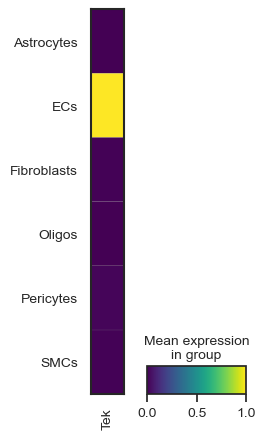

In [136]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

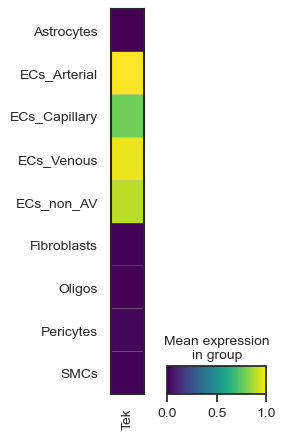

In [137]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

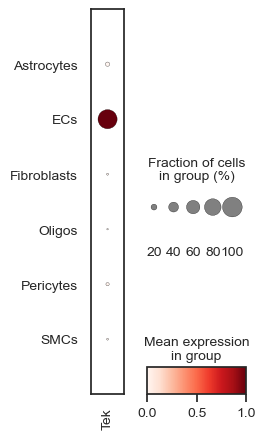

In [138]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

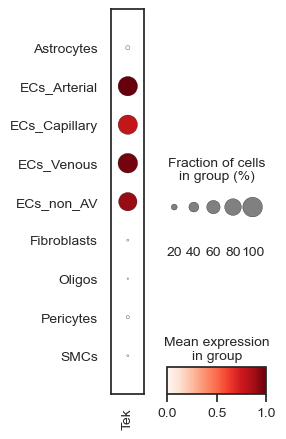

In [139]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [140]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,1.000000
Fibroblasts,0.004707
Oligos,0.000559
Pericytes,0.014129
SMCs,0.004933


In [141]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.132000
ECs,0.965969
Fibroblasts,0.046512
Oligos,0.032258
Pericytes,0.091912
SMCs,0.043771


In [142]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.132000,Tek,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.965969,Tek,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.004707,0.046512,Tek,Vanlandewijck2018,Mouse,86
Oligos,0.000559,0.032258,Tek,Vanlandewijck2018,Mouse,155
Pericytes,0.014129,0.091912,Tek,Vanlandewijck2018,Mouse,1088
SMCs,0.004933,0.043771,Tek,Vanlandewijck2018,Mouse,297


In [143]:
# export
name='Vanlandewijck2018'

In [144]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [145]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [146]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [147]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.132000,Tek,Vanlandewijck2018,Mouse,250
ECs_Arterial,1.000000,0.984887,Tek,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.779048,0.977778,Tek,Vanlandewijck2018,Mouse,405
ECs_Venous,0.970054,0.996644,Tek,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.895323,0.915888,Tek,Vanlandewijck2018,Mouse,428
Fibroblasts,0.004266,0.046512,Tek,Vanlandewijck2018,Mouse,86
Oligos,0.000507,0.032258,Tek,Vanlandewijck2018,Mouse,155
Pericytes,0.012805,0.091912,Tek,Vanlandewijck2018,Mouse,1088
SMCs,0.004471,0.043771,Tek,Vanlandewijck2018,Mouse,297


In [148]:
# export
name='Vanlandewijck2018'

In [149]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Nos3 = eNOS

In [150]:
gene="Nos3"

### Plot

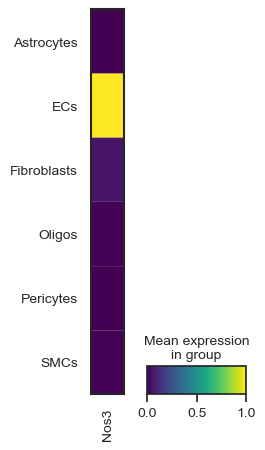

In [151]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

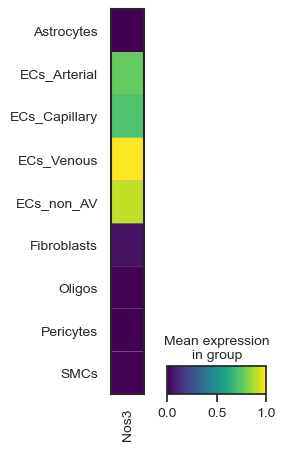

In [152]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

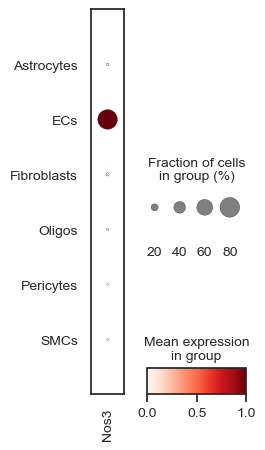

In [153]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

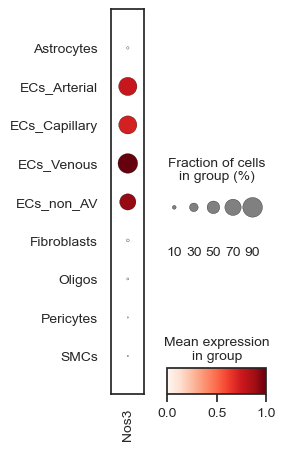

In [154]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [155]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000000
ECs,1.000000
Fibroblasts,0.052781
Oligos,0.005379
Pericytes,0.003093
SMCs,0.005031


In [156]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.056000
ECs,0.797120
Fibroblasts,0.069767
Oligos,0.045161
Pericytes,0.023897
SMCs,0.026936


In [157]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000000,0.056000,Nos3,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.797120,Nos3,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.052781,0.069767,Nos3,Vanlandewijck2018,Mouse,86
Oligos,0.005379,0.045161,Nos3,Vanlandewijck2018,Mouse,155
Pericytes,0.003093,0.023897,Nos3,Vanlandewijck2018,Mouse,1088
SMCs,0.005031,0.026936,Nos3,Vanlandewijck2018,Mouse,297


In [158]:
# export
name='Vanlandewijck2018'

In [159]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [160]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [161]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [162]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.000000,0.056000,Nos3,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.758944,0.816121,Nos3,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.719942,0.807407,Nos3,Vanlandewijck2018,Mouse,405
ECs_Venous,1.000000,0.899329,Nos3,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.903684,0.698598,Nos3,Vanlandewijck2018,Mouse,428
Fibroblasts,0.044134,0.069767,Nos3,Vanlandewijck2018,Mouse,86
Oligos,0.004498,0.045161,Nos3,Vanlandewijck2018,Mouse,155
Pericytes,0.002586,0.023897,Nos3,Vanlandewijck2018,Mouse,1088
SMCs,0.004207,0.026936,Nos3,Vanlandewijck2018,Mouse,297


In [163]:
# export
name='Vanlandewijck2018'

In [164]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Htra1

In [100]:
gene="Htra1"

### Plot

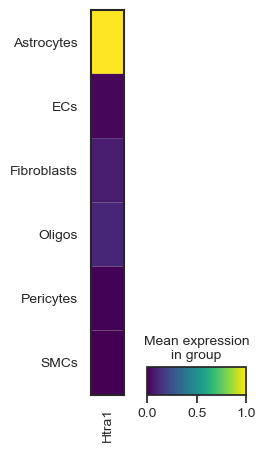

In [101]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

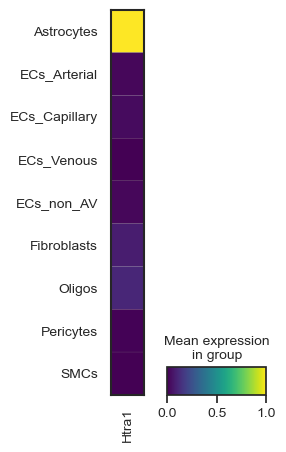

In [102]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

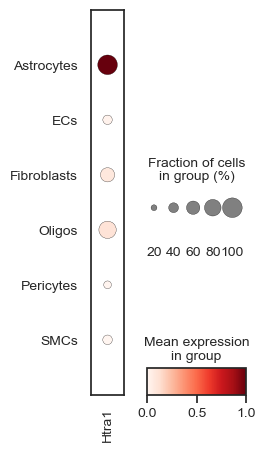

In [103]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

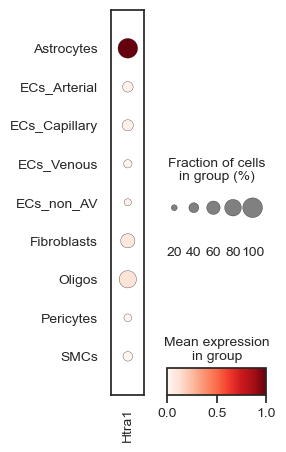

In [104]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [105]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,1.000000
ECs,0.017986
Fibroblasts,0.080460
Oligos,0.107076
Pericytes,0.007577
SMCs,0.000000


In [106]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,1.000000
ECs,0.375000
Fibroblasts,0.651163
Oligos,0.845161
Pericytes,0.288603
SMCs,0.383838


In [107]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,1.000000,1.000000,Htra1,Vanlandewijck2018,Mouse,250
ECs,0.017986,0.375000,Htra1,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.080460,0.651163,Htra1,Vanlandewijck2018,Mouse,86
Oligos,0.107076,0.845161,Htra1,Vanlandewijck2018,Mouse,155
Pericytes,0.007577,0.288603,Htra1,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.383838,Htra1,Vanlandewijck2018,Mouse,297


In [108]:
# export
name='Vanlandewijck2018'

In [109]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [110]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [111]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [112]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,1.000000,1.000000,Htra1,Vanlandewijck2018,Mouse,250
ECs_Arterial,0.018875,0.438287,Htra1,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.028745,0.474074,Htra1,Vanlandewijck2018,Mouse,405
ECs_Venous,0.000967,0.318792,Htra1,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.018832,0.261682,Htra1,Vanlandewijck2018,Mouse,428
Fibroblasts,0.080460,0.651163,Htra1,Vanlandewijck2018,Mouse,86
Oligos,0.107076,0.845161,Htra1,Vanlandewijck2018,Mouse,155
Pericytes,0.007577,0.288603,Htra1,Vanlandewijck2018,Mouse,1088
SMCs,0.000000,0.383838,Htra1,Vanlandewijck2018,Mouse,297


In [113]:
# export
name='Vanlandewijck2018'

In [114]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Egfl8

In [116]:
gene="Egfl8"

### Plot

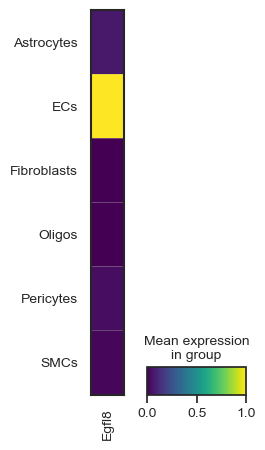

In [117]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

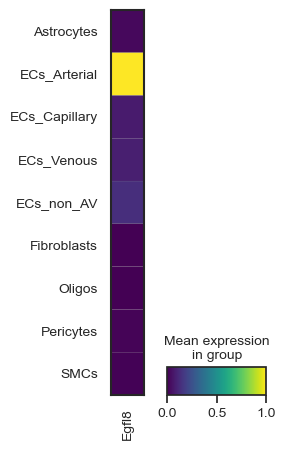

In [118]:
sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

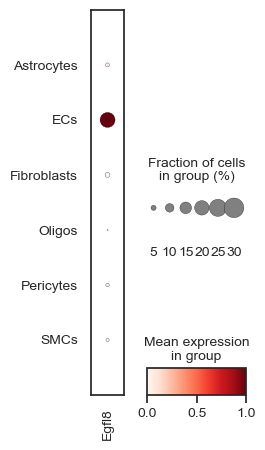

In [119]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var")

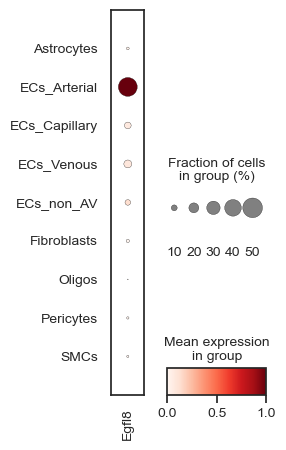

In [120]:
sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var")

### Excl zonation

In [121]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.062616
ECs,1.000000
Fibroblasts,0.001564
Oligos,0.000000
Pericytes,0.033888
SMCs,0.019324


In [122]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.036000
ECs,0.209424
Fibroblasts,0.046512
Oligos,0.006452
Pericytes,0.029412
SMCs,0.026936


In [123]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.062616,0.036000,Egfl8,Vanlandewijck2018,Mouse,250
ECs,1.000000,0.209424,Egfl8,Vanlandewijck2018,Mouse,1528
Fibroblasts,0.001564,0.046512,Egfl8,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.006452,Egfl8,Vanlandewijck2018,Mouse,155
Pericytes,0.033888,0.029412,Egfl8,Vanlandewijck2018,Mouse,1088
SMCs,0.019324,0.026936,Egfl8,Vanlandewijck2018,Mouse,297


In [124]:
# export
name='Vanlandewijck2018'

In [125]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'.csv',sep=';')

### Incl zonation

In [126]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [127]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(ad_merged, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [128]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Vanlandewijck2018"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(ad_merged.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters2,,,,,,
Astrocytes,0.020811,0.036000,Egfl8,Vanlandewijck2018,Mouse,250
ECs_Arterial,1.000000,0.473552,Egfl8,Vanlandewijck2018,Mouse,397
ECs_Capillary,0.072577,0.118519,Egfl8,Vanlandewijck2018,Mouse,405
ECs_Venous,0.084823,0.147651,Egfl8,Vanlandewijck2018,Mouse,298
ECs_non_AV,0.131257,0.093458,Egfl8,Vanlandewijck2018,Mouse,428
Fibroblasts,0.000520,0.046512,Egfl8,Vanlandewijck2018,Mouse,86
Oligos,0.000000,0.006452,Egfl8,Vanlandewijck2018,Mouse,155
Pericytes,0.011263,0.029412,Egfl8,Vanlandewijck2018,Mouse,1088
SMCs,0.006423,0.026936,Egfl8,Vanlandewijck2018,Mouse,297


In [129]:
# export
name='Vanlandewijck2018'

In [130]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

# Session Info

In [165]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.3.0
h5py                        3.6.0
hypergeom_ufunc             NA
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.7.0
jedi                        0.18.1
jinja2 